<a href="https://colab.research.google.com/github/mohdshadan2332-bit/codealpha_tasks/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install any missing libraries
!pip install shap streamlit joblib xgboost --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.3 MB/s eta 0:00:00


In [6]:
from google.colab import files
uploaded = files.upload()  # Upload 'student-mat.csv'


Saving student-mat.csv to student-mat.csv


In [7]:
df = pd.read_csv("student-mat.csv", sep=";")
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Shape: (395, 33)
Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 

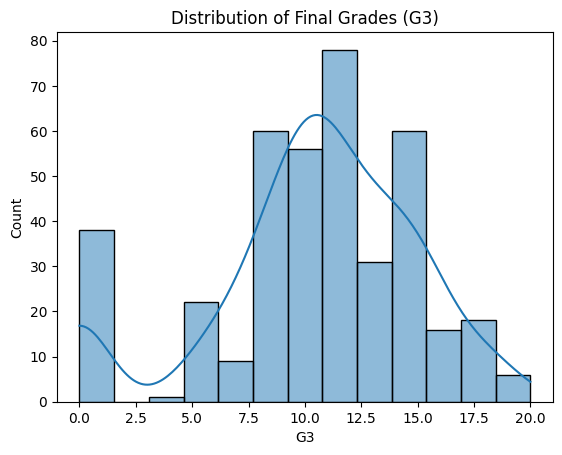

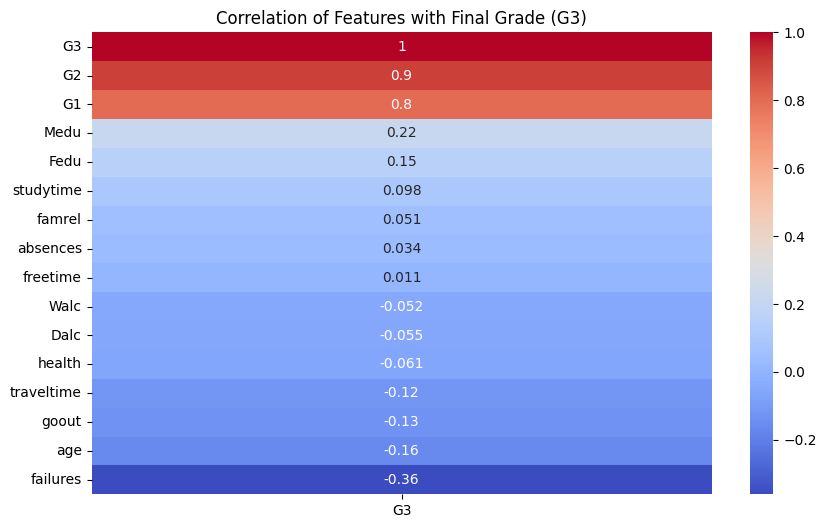

In [8]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.info()
df.describe()

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Visualize target variable (G3)
sns.histplot(df['G3'], kde=True)
plt.title("Distribution of Final Grades (G3)")
plt.show()

# Correlation with G3
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True)[['G3']].sort_values(by='G3', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Final Grade (G3)")
plt.show()


In [9]:
# Create a 'passed' column for classification (1 = passed, 0 = failed)
df['passed'] = (df['G3'] >= 10).astype(int)

# Define features and target
X = df.drop(['G3', 'passed'], axis=1)
y = df['G3']  # regression target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Preprocessor pipeline
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


Numeric columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']
Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ----- Linear Regression -----
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Convert to numeric arrays to avoid TypeError
y_test_num = np.array(y_test).astype(float).ravel()
y_pred_lr_num = np.array(y_pred_lr).astype(float).ravel()

print("📘 Linear Regression Results:")
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_num, y_pred_lr_num)), 3)) # Calculate RMSE manually
print("MAE :", round(mean_absolute_error(y_test_num, y_pred_lr_num), 3))
print("R²  :", round(r2_score(y_test_num, y_pred_lr_num), 3))
print("-" * 40)


# ----- Random Forest Regression -----
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

y_pred_rf_num = np.array(y_pred_rf).astype(float).ravel()

print("🌲 Random Forest Results:")
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_num, y_pred_rf_num)), 3)) # Calculate RMSE manually
print("MAE :", round(mean_absolute_error(y_test_num, y_pred_rf_num), 3))
print("R²  :", round(r2_score(y_test_num, y_pred_rf_num), 3))
print("-" * 40)


# ----- Optional: comparison table -----
import pandas as pd

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_num, y_pred_lr_num)), # Calculate RMSE manually
        np.sqrt(mean_squared_error(y_test_num, y_pred_rf_num))  # Calculate RMSE manually
    ],
    'MAE': [
        mean_absolute_error(y_test_num, y_pred_lr_num),
        mean_absolute_error(y_test_num, y_pred_rf_num)
    ],
    'R²': [
        r2_score(y_test_num, y_pred_lr_num),
        r2_score(y_test_num, y_pred_rf_num)
    ]
})

print("\n📊 Model Comparison:")
display(results.round(3))

📘 Linear Regression Results:
RMSE: 2.378
MAE : 1.647
R²  : 0.724
----------------------------------------
🌲 Random Forest Results:
RMSE: 2.015
MAE : 1.201
R²  : 0.802
----------------------------------------

📊 Model Comparison:


,Model,RMSE,MAE,R²
0,Linear Regression,2.378,1.647,0.724
1,Random Forest,2.015,1.201,0.802


/tmp/ipython-input-1887020661.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


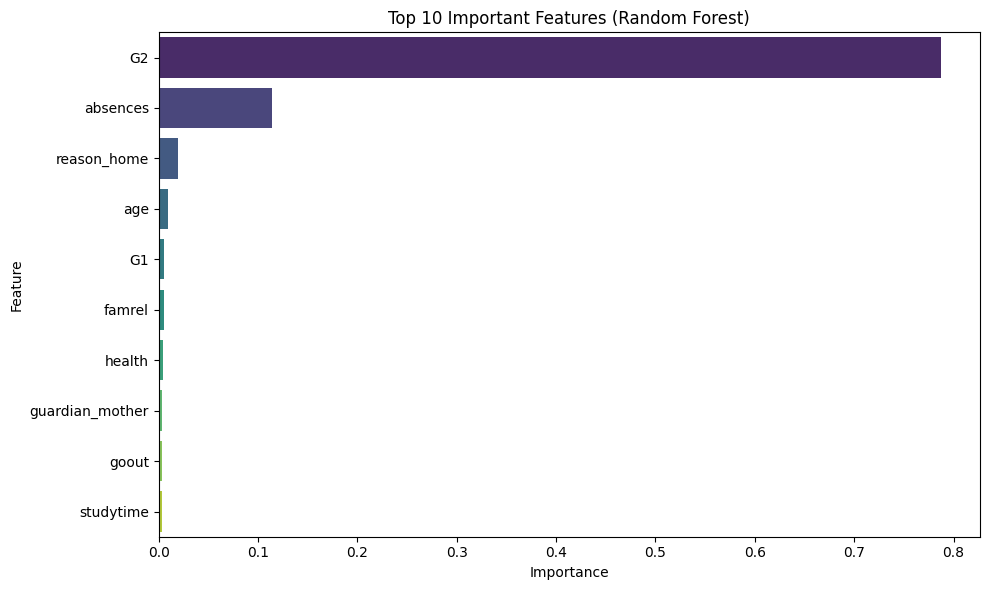

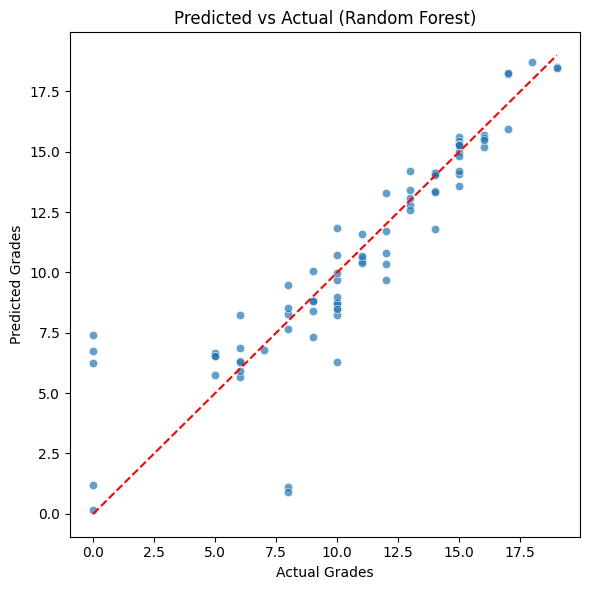

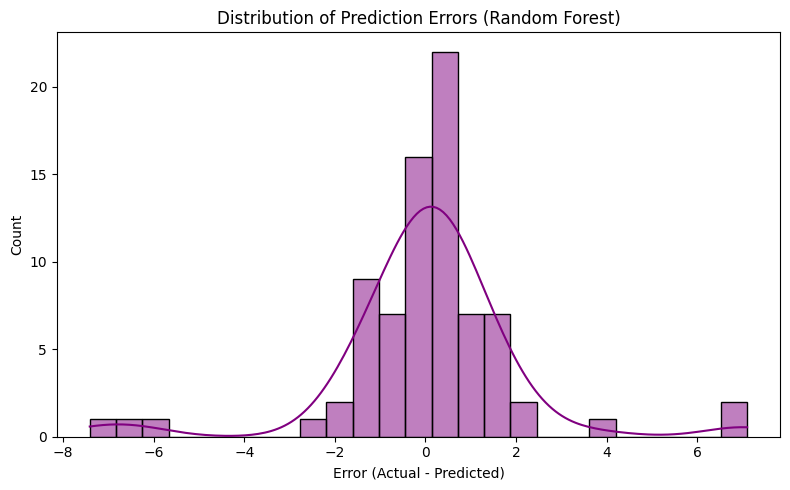

✅ Step 6 complete — you now have:
• Feature importance ranking
• Predicted vs actual scatterplot
• Error distribution visualization


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ----- 1️⃣ Feature Importance for Random Forest -----
# Get feature names from preprocessor
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
num_features = num_cols
all_features = np.concatenate([num_features, cat_features])

# Extract feature importances
importances = rf_model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# ----- 2️⃣ Compare Predicted vs Actual -----
# Convert to numeric arrays to avoid TypeError in plotting
y_test_num = np.array(y_test).astype(float)
y_pred_rf_num = np.array(y_pred_rf).astype(float)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_num, y=y_pred_rf_num, alpha=0.7)
plt.plot([y_test_num.min(), y_test_num.max()],
         [y_test_num.min(), y_test_num.max()],
         color='red', linestyle='--')
plt.title("Predicted vs Actual (Random Forest)")
plt.xlabel("Actual Grades")
plt.ylabel("Predicted Grades")
plt.tight_layout()
plt.show()


# ----- 3️⃣ Distribution of Prediction Errors -----
errors = y_test_num - y_pred_rf_num
plt.figure(figsize=(8,5))
sns.histplot(errors, kde=True, color='purple')
plt.title("Distribution of Prediction Errors (Random Forest)")
plt.xlabel("Error (Actual - Predicted)")
plt.tight_layout()
plt.show()


# ----- 4️⃣ Summary -----
print("✅ Step 6 complete — you now have:")
print("• Feature importance ranking")
print("• Predicted vs actual scatterplot")
print("• Error distribution visualization")